<a href="https://colab.research.google.com/github/avncalst/drone_cnn/blob/master/quantClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q tf-nightly
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 410.0MB 39kB/s 
     |████████████████████████████████| 4.0MB 52.9MB/s 
     |████████████████████████████████| 471kB 55.3MB/s 
     |████████████████████████████████| 6.1MB 47.3MB/s 
     |████████████████████████████████| 4.0MB 41.4MB/s 
     |████████████████████████████████| 3.8MB 54.3MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
     |████████████████████████████████| 174kB 8.0MB/s 


In [2]:
# create symbolic link
!ln -s "drive/MyDrive/Colab Notebooks/Tensorflow" "./Tensorflow"
!dir

drive  sample_data  Tensorflow


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
import pandas as pd
import imageio
import re
import random
import cv2
import json
import glob
import pathlib
import PIL

from tensorflow.keras.applications import MobileNetV2
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil
import os


from tensorflow.keras.layers import Permute,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file



In [ ]:
df = pd.DataFrame([pd.read_json('/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_531.json',
typ='series')])
# df1 = pd.DataFrame([pd.read_json('/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_530.json',
# typ='series')])
# df1 = df1.append(df,ignore_index=True)

list_json = glob.glob("/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/*.json")
for itx, f in enumerate(list_json):
    print(itx,f)
    df1 = pd.DataFrame([pd.read_json(f,typ='series')])
    df = df.append(df1,ignore_index=True)
df.head()
df = df.drop_duplicates()
df.tail()



# with open('record_1.json') as json_file: 
#     data = json.load(json_file)
# print(data,)     

# df=pd.DataFrame(data,index=[0])
# df=df.append(data,ignore_index=True)

# y = json.loads(f)
# print(y)
# df1.head()
# df.head()

b/tub_7_20-03-18/record_478.json
2041 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_1009.json
2042 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_116.json
2043 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_324.json
2044 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_35.json
2045 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_1257.json
2046 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_1026.json
2047 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_256.json
2048 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_249.json
2049 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_1179.json
2050 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_819.json
2051 /home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/record_1237.json
2052 /home/avncalst/Dropbox/

,cam/image_array,user/angle,user/throttle,user/mode,milliseconds
2060,1661_cam-image_array_.jpg,0.3,0.0,user,169302
2061,1542_cam-image_array_.jpg,-0.3,0.0,user,157173
2062,1981_cam-image_array_.jpg,0.9,0.0,user,201925
2063,614_cam-image_array_.jpg,-0.9,0.0,user,62580
2064,1129_cam-image_array_.jpg,-0.3,0.0,user,115076


2291


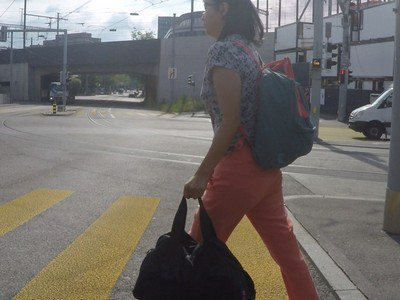

In [5]:
data_dir = 'Tensorflow/workspace/images/imag_2'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
imag = list(data_dir.glob('left/*'))
PIL.Image.open(str(imag[0]))


In [6]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2291 files belonging to 4 classes.
Using 1833 files for training.
Found 2291 files belonging to 4 classes.
Using 458 files for validation.


In [7]:
# Image resize
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [8]:
# Normalization utils
def normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

In [9]:
train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

In [10]:
def get_training_model():
    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
    EXTRACTOR.trainable = True
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)
    
    return classifier

In [11]:
quant_model = get_training_model()
q_quant_model = tfmot.quantization.keras.quantize_model(quant_model)
q_quant_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])
start = time.time()
history = q_quant_model.fit(train_ds,
              validation_data=val_ds,
              epochs=25)
end = time.time()-start
print("Model takes {} seconds to train ",end)

9412608/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:500: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/25
58/58 [==============================] - 512s 7s/step - loss: 1.7897 - accuracy: 0.2704 - val_loss: 1.2864 - val_accuracy: 0.5262
Epoch 2/25
58/58 [==============================] - 28s 473ms/step - loss: 0.9408 - accuracy: 0.6705 - val_loss: 1.0685 - val_accuracy: 0.6245
Epoch 3/25
58/58 [==============================] - 28s 471ms/step - loss: 0.6489 - accuracy: 0.7825 - val_loss: 0.9467 - val_accuracy: 0.6921
Epoch 4/25
58/58 [==============================] - 28s 471ms/step - loss: 0.5672 - accuracy: 0.8138 - val_loss: 0.8785 - val_accuracy: 0.6987
Epoch 5/25
58/58 [==============================] - 28s 464ms/step - loss: 0.4455 - accuracy: 0.8545 - val_loss: 0.8045 - val_accuracy: 0.7336
Epoch 6/25
58/58 [==============================] - 28s 474ms/step - loss: 0.3781 - accuracy: 0.8818 - val_loss: 0.7217 - val_accuracy: 0.7598
Epoch 7/25
58/58 [==============================] - 28s 474ms/step - loss: 0.3287 - accuracy: 0.8920 - val_loss: 0.6237 - val_accuracy: 0.7969
E

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_quant_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:500: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpdxf15beo/assets


INFO:tensorflow:Assets written to: /tmp/tmpdxf15beo/assets


In [13]:
with open('w_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

  !ls -lh w_tflite_model.tflite

-rw-r--r-- 1 root root 3.3M Mar  3 18:10 w_tflite_model.tflite
